# Probabilistic Methods (Discrete)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

**Anomaly Detection:** Identification of items, events or observations which is significantly different from the remaining data.

- Non-parametric approach
- Frequency or counting based
    - How many time a value of variable (e.g. ip address) shows up
    - More frequent - less likely to be an anomaly
    - less frequent - more likely to be an anomaly
    - Calculate probability 

    
- Conditional probability 
    $$ {P(A|B) = }\frac{\text{P(A U B)}}{\text{P(B)}} $$
    
    
 Examples: 
- How many times we see an ip address in the dataset (count)
- What is probability of ip address showing up in the dataset (ip count / total observations)
- Conditional probability. Given an ip address, what is prob of a particular status(e.g authentication failure)

# Exercise Prompt
Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

-started with class copy. Expanded copy to include "examine the rest of the features in the api access logs data set" per the prompt

### Wrangle

The data comes from the webserver logs of the API that we used in the timeseries module. Each row is one request to the server

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)

In [3]:
df.head(2)

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...


In [4]:
df['entry'][0]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/sales?page=81 HTTP/1.1" 200 512495 "-" "python-requests/2.21.0"'

In [5]:
df['entry'][1]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/items HTTP/1.1" 200 3561 "-" "python-requests/2.21.0"'

In [6]:
df['entry'][0].split()

['97.105.19.58',
 '-',
 '-',
 '[16/Apr/2019:19:34:42',
 '+0000]',
 '"GET',
 '/api/v1/sales?page=81',
 'HTTP/1.1"',
 '200',
 '512495',
 '"-"',
 '"python-requests/2.21.0"']

In [7]:
parts = df['entry'][0].split()
output = {}
output['ip'] = parts[0]

In [8]:
parts[3][1:] #start at third entry (count starts at zero)

'16/Apr/2019:19:34:42'

In [9]:
parts[3] #the only differenct i see is an open '[' and no close ']'

'[16/Apr/2019:19:34:42'

In [52]:
type(parts[3])

str

In [53]:
type(parts[3][1:])

str

In [54]:
type(parts)

list

In [10]:
output['timestamp'] = parts[3][1:].replace(':', ' ', 1) #replace : with ' ' the first time you see :


In [11]:
output['timestamp']

'16/Apr/2019 19:34:42'

In [12]:
pd.Series(output)

ip                   97.105.19.58
timestamp    16/Apr/2019 19:34:42
dtype: object

In [13]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [14]:
df = df.entry.apply(parse_log_entry)

In [15]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [16]:
# Synthetic data added for class purposes. I removed it hear

In [17]:
# # Synthetic data
# new = pd.DataFrame([
#     ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
#     ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
#     ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
#     ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
# ], columns=df.columns)

# df = df.append(new)

In [18]:
df['size_mb'] = df['size'] / 1024 / 1024  # In binary notation, 1024 is represented as 10000000000
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [19]:
df.head(2)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396


## Detecting Anomalies in Discrete Variables

- **count**: the number of times each unique value appears in the dataset
- **frequencies**: the number of times each unique value appears in the dataset as a percentage of the total; the count divided by the total number of observations

# Hard way .value_counts(normalize = False)

In [20]:
# df.ip.value_counts()

In [21]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'count'})
ip_df.head()

,ip,count
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21


In [22]:
# calculate probabity for each ip 

# ip_prob = count for each ip / total count in the dataframe

ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'proba'})
ip_df2.head()

,ip,proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503


In [23]:
# merge the two data frames create above into a single one:
ip_df = ip_df.merge(ip_df2, on='ip')
ip_df.head()

,ip,count,proba
0,97.105.19.58,11998,0.858595
1,173.173.113.51,1059,0.075784
2,72.181.113.170,613,0.043867
3,72.181.105.81,246,0.017604
4,24.26.242.9,21,0.001503


From here we can find how many unique ip addresses there are:

In [24]:
ip_df.set_index('ip')['count'].sort_values()

ip
54.145.52.184         1
52.91.30.150          1
3.88.129.158          1
34.207.64.242         1
54.172.14.223         1
34.229.70.250         1
35.174.209.2          1
3.92.201.136          1
52.90.165.200         1
45.23.250.16          1
52.87.230.102         2
70.121.214.34         2
35.175.171.137        2
68.201.219.223       21
24.26.242.9          21
72.181.105.81       246
72.181.113.170      613
173.173.113.51     1059
97.105.19.58      11998
Name: count, dtype: int64

<AxesSubplot:ylabel='ip'>

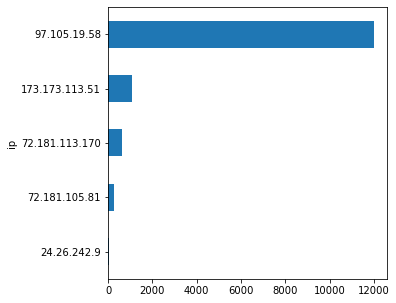

In [25]:
ip_df.set_index('ip')['count'].sort_values().tail(5).plot.barh(figsize=(5,5))

<AxesSubplot:ylabel='ip'>

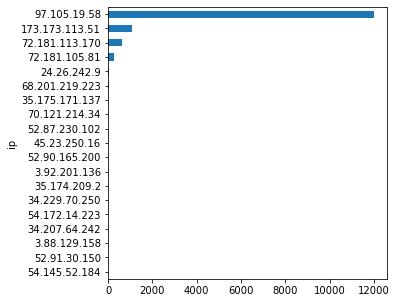

In [26]:
ip_df.set_index('ip')['count'].sort_values().plot.barh(figsize=(5,5))

### Conditional Probabilities

- What is probability of a certain status code given an IP address?

HTTP Status Codes

- 200: ok
- 3xx: redirects
- 4xx: client level errors -- the requester did something wrong
- 5xx: server level errors -- the server did something wrong

In [27]:
# prob(A|B) = prob(A & B)/prob(B)

In [28]:
Pab = df.groupby(['ip', 'status_code']).size()/len(df)

In [29]:
Pab

ip              status_code
173.173.113.51  200            0.075784
24.26.242.9     200            0.001503
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
34.229.70.250   200            0.000072
35.174.209.2    200            0.000072
35.175.171.137  200            0.000143
45.23.250.16    200            0.000072
52.87.230.102   200            0.000143
52.90.165.200   200            0.000072
52.91.30.150    200            0.000072
54.145.52.184   200            0.000072
54.172.14.223   200            0.000072
68.201.219.223  200            0.001503
70.121.214.34   200            0.000143
72.181.105.81   200            0.017604
72.181.113.170  200            0.043724
                499            0.000143
97.105.19.58    200            0.857593
                499            0.001002
dtype: float64

In [30]:
Pb = df.groupby('ip').size()/len(df)

In [31]:
Pb

ip
173.173.113.51    0.075784
24.26.242.9       0.001503
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001503
70.121.214.34     0.000143
72.181.105.81     0.017604
72.181.113.170    0.043867
97.105.19.58      0.858595
dtype: float64

In [32]:
Pab / Pb

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
97.105.19.58    200            0.998833
                499            0.001167
dtype: float64

# Easy method, normalize = True

In [33]:
# Given a particular ip, what is probability of a certain status code
status_given_ip = (
    df.groupby('ip')\
    .status_code.value_counts(normalize=True)\
    .rename('proba_status_given_ip')\
    .reset_index())
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


# Warning
in the below, it is a goood thing to do, but note you miss any anomaly that happened 100% of the time
ie. 301 is an anomaly, but it happened the one time 97.105.15.120 tried to log on, which is 100% of the time 97.105.15.120 tried to log on

so multi-index anomalies may be missed if only approached at one angle

In [34]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


In [35]:
df[df.ip == '72.181.113.170'].sort_values(by='status_code', ascending=False)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-17 02:48:36,72.181.113.170,GET,/api/v1/sales?page=8,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:44,72.181.113.170,GET,/api/v1/sales?page=133,HTTP/1.1,499,0,python-requests/2.21.0,0.000000
2019-04-17 03:42:17,72.181.113.170,GET,/api/v1/sales?page=120,HTTP/1.1,200,510681,python-requests/2.21.0,0.487023
2019-04-17 03:42:01,72.181.113.170,GET,/api/v1/sales?page=113,HTTP/1.1,200,511094,python-requests/2.21.0,0.487417
2019-04-17 03:42:03,72.181.113.170,GET,/api/v1/sales?page=114,HTTP/1.1,200,511291,python-requests/2.21.0,0.487605
...,...,...,...,...,...,...,...,...
2019-04-17 03:28:07,72.181.113.170,GET,/api/v1/sales?page=100,HTTP/1.1,200,512674,python-requests/2.21.0,0.488924
2019-04-17 03:28:08,72.181.113.170,GET,/api/v1/sales?page=101,HTTP/1.1,200,510509,python-requests/2.21.0,0.486859
2019-04-17 03:28:11,72.181.113.170,GET,/api/v1/sales?page=102,HTTP/1.1,200,512612,python-requests/2.21.0,0.488865


* Cases where the probability is < 100%
* Status codes other than 200

In [36]:
status_given_ip[status_given_ip.status_code != 200]

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


#### How do we use this if we are looking to apply assumptions on unseen data?

In [37]:
# create a training set
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [38]:
train.size / df.size

1.0

#### Add these probabilities to original events to detect anomalous events:

In [39]:
status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [40]:
# look at any unseen data in df versus assumptions made on train

In [41]:
df = df.reset_index().merge(status_given_ip, on=['ip', 'status_code'], how='left').fillna(value=0).set_index('timestamp')

In [42]:
df[df.proba_status_given_ip < 0.15]

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:55:15,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.001167
2019-04-16 19:56:02,97.105.19.58,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.001167
2019-04-16 20:28:46,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:33:24,97.105.19.58,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:38:13,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:38:55,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:39:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:45:17,97.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167
2019-04-16 20:45:28,97.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.001167


# playing with strings

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13974 entries, 2019-04-16 19:34:42 to 2019-04-17 12:55:14
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ip                     13974 non-null  object 
 1   request_method         13974 non-null  object 
 2   request_path           13974 non-null  object 
 3   http_version           13974 non-null  object 
 4   status_code            13974 non-null  object 
 5   size                   13974 non-null  int64  
 6   user_agent             13974 non-null  object 
 7   size_mb                13974 non-null  float64
 8   proba_status_given_ip  13974 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 1.1+ MB


# what are the non-page request paths?

In [44]:
df.head(11)

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,0.998833
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,0.998833
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,0.998833
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377,0.998833
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246,0.998833
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0.001266,0.998833
2019-04-16 19:34:50,97.105.19.58,GET,/api/v1/sales?page=85,HTTP/1.1,200,510753,python-requests/2.21.0,0.487092,0.998833
2019-04-16 19:34:52,97.105.19.58,GET,/api/v1/sales?page=86,HTTP/1.1,200,510348,python-requests/2.21.0,0.486706,0.998833
2019-04-16 19:34:52,97.105.19.58,GET,/,HTTP/1.1,200,42,python-requests/2.21.0,0.000040,0.998833


In [45]:
df_not_page = df[df.request_path.str.contains('page') == False]

In [46]:
df_not_page.request_path.unique()

array(['/api/v1/items', '/api/v1/stores', '/', '/api/v1/sales',
       '/documentation', '/api/V1/HiZach!', '/favicon.ico', '/api/v1/',
       '/api/v1//api/v1/items', '/api/v1items', '/api/v1',
       '/api/v1/helloclass!', '/api/v1/I_DIDNT_DO_IT!!!!',
       '/api/v1/itemsitems', '/api/v1/store'], dtype=object)

In [47]:
# I would say "helloclass!", "I_DIDNT_DO_IT!!!!", "HiZach!" are anomalies

In [48]:
df[df.request_path.str.contains('Zach')]

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:38:16,97.105.19.58,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833


# user agent anomalies?

In [49]:
df_not_python = df[df.user_agent.str.contains('requests')==False]
df_not_python.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:38:16,97.105.19.58,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833
2019-04-16 19:38:16,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.998833
2019-04-16 19:39:14,3.92.201.136,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040,1.000000
2019-04-16 19:39:15,52.90.165.200,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,1.000000
2019-04-16 19:40:32,3.88.129.158,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396,1.000000


In [50]:
df_not_python.shape

(62, 9)

In [51]:
df_not_python = df_not_python[df_not_python.user_agent.str.contains('Mac')==False]
df_not_python

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,proba_status_given_ip
timestamp,,,,,,,,,
2019-04-16 19:39:14,3.92.201.136,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040,1.000000
2019-04-16 19:39:15,52.90.165.200,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,1.000000
2019-04-16 19:40:32,3.88.129.158,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396,1.000000
2019-04-16 19:40:33,34.207.64.242,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,1.000000
2019-04-16 19:40:36,54.172.14.223,GET,/api/v1/,HTTP/1.1,200,162,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000154,1.000000
2019-04-16 19:40:37,34.229.70.250,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,1.000000
2019-04-16 20:57:38,97.105.19.58,GET,/api/v1/items&page=0,HTTP/1.1,200,162,Python-urllib/3.7,0.000154,0.998833
2019-04-16 21:22:22,35.175.171.137,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040,1.000000
2019-04-16 21:22:22,54.145.52.184,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,1.000000
